In [1]:
# load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# read data
df = pd.read_csv('DOGE-USD-daily 2021.csv', index_col = 0, header = 0)
df.dropna()
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,0.004681,0.005685,0.004615,0.005685,0.005685,228961515
2021-01-02,0.005686,0.013698,0.005584,0.010615,0.010615,3421562680
2021-01-03,0.010602,0.013867,0.009409,0.009771,0.009771,2707003608
2021-01-04,0.009785,0.011421,0.007878,0.009767,0.009767,1372398979
2021-01-05,0.009767,0.010219,0.008972,0.009920,0.009920,687256067
...,...,...,...,...,...,...
2022-07-16,0.063037,0.064725,0.061870,0.064280,0.064280,279644299
2022-07-17,0.064288,0.065394,0.063101,0.063107,0.063107,249697026
2022-07-18,0.063114,0.068674,0.063114,0.067715,0.067715,564795959


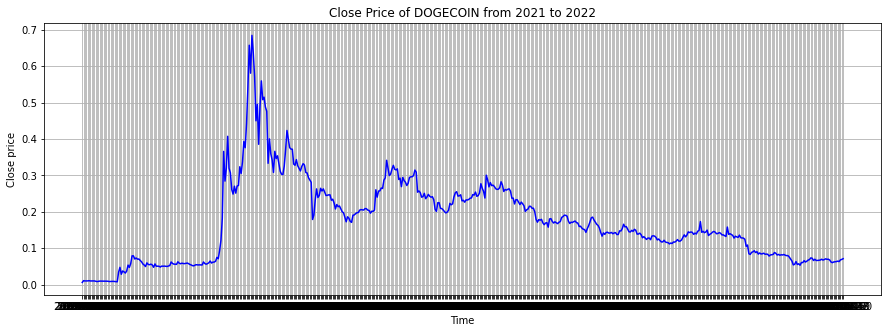

In [3]:
# Close Price of DOGECOIN from 2021 to 2022
close_price = df["Close"]
# show close price change
plt.figure(figsize=(15,5))
plt.plot(close_price, linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Close price')
plt.title('Close Price of DOGECOIN from 2021 to 2022')
plt.grid(True)
plt.show()

In [4]:
# calculate MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [5]:
# create lag variable
def create_lag(data, lag):
    dataframe = pd.DataFrame()
    for i in range(lag, 0, -1):
        dataframe['t-' + str(i)] = data.shift(i)
    final_data = pd.concat([data, dataframe], axis=1)
    final_data.dropna(inplace=True)
    final_data.reset_index(inplace=True)
    return final_data
# split data
def split_data(final_data, test_length = 30):
    new_data = final_data.drop(['Date'], axis=1)
    new_data = new_data.reset_index(drop=True)
    end_point = len(new_data)
    x = end_point - test_length
    train = new_data.loc[:x - 1, :]
    test = new_data.loc[x:, :]
    test_x = test.loc[:, test.columns != 'Close']
    test_y = test['Close']
    train_x = train.loc[:, train.columns != 'Close']
    train_y = train['Close']
    return test_x, test_y, train_x, train_y
# predict
def predict (regressor, train_x, train_y, test_x, test_y):
    fit = regressor.fit(train_x, train_y)
    y_pred = fit.predict(test_x)
    # evaluate
    mse = mean_squared_error(test_y,y_pred)
    mape_rf = mape(test_y, y_pred)
    return y_pred, mape_rf, mse

In [6]:
# tune the model
regressor0 = RandomForestRegressor(n_estimators=1000)
final_data0 = create_lag(close_price, 1)
test_x0, test_y0, train_x0, train_y0 = split_data(final_data0)
y_pred0, mape_rf0, mse0 = predict(regressor0, train_x0, train_y0, test_x0, test_y0)
final = y_pred0
min_mse = mse0
min_mape = mape_rf0
l = 1

for lag in range (2, 13):
    regressor = RandomForestRegressor(n_estimators=1000)
    final_data = create_lag(close_price, lag)
    test_x, test_y, train_x, train_y = split_data(final_data)
    print("Starting model train..")
    y_pred, mape_rf, mse = predict(regressor, train_x, train_y, test_x, test_y)
    if mse < min_mse:
        min_mse = mse
        min_mape = mape_rf
        final = y_pred
        l = lag
print(min_mse)
print(min_mape)
print(l)

Starting model train..
Starting model train..
Starting model train..
Starting model train..
Starting model train..
Starting model train..
Starting model train..
Starting model train..
Starting model train..
Starting model train..
Starting model train..
1.9544088402847747e-05
4.910333718887496
3


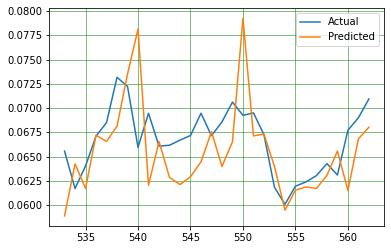

mape is 4.8709564331343795
mse is 1.921104352533034e-05
accuracy is 95.12904356686562%


In [7]:
# the best model is lag = 3
regressor = RandomForestRegressor(n_estimators=1000)
final_data = create_lag(close_price, 3)
test_x, test_y, train_x, train_y = split_data(final_data)
y_pred, mape_rf, mse = predict(regressor, train_x, train_y, test_x, test_y)

df1 = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})
df1.plot(kind='line')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plot and print the result
plt.show()
print(f'mape is {mape_rf}')
print(f'mse is {mse}')
print(f'accuracy is {100-mape_rf}%')